# A notebook for calculating recurrence interval

_This notebook was created by Neta Wechsler._

Recurrence interval between earthquake C14 dates, based on random sample generation from discrete distributions with the Alias method

This notebook uses the dates text files generated by OxCal, and assumes tab separation.

The files in the example are from Wechsler et al. 2018[1]

### **The file names must correspond to their chronological order and be ordered chronologically.**

[1] Wechsler, N., Rockwell, T. K., Klinger, Y., 2018, Variable Slip-Rate and Slip-Per-Event on a Plate Boundary Fault: The Dead Sea Fault in northern Israel, Tectonophysics, Vol. 722, pp. 210-226. DOI 10.1016/j.tecto.2017.10.017

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import sys
sys.path.append('./src')
from alias import *

If the file names are in __increasing__ chronological order, please change the `REVERSE` flag to `False`

In [2]:
# set path to folder containing distribution text files
path = "files/"

# If the file names, when alphabetically sorted, are in _increasing_ chronological order -  
# change this flag to False
REVERSE = True
if os.path.isdir(path):
    files = [path+f for f in os.listdir(path) if f.endswith('.prior')]
print("The list of files to process is:", *sorted(files, reverse=REVERSE), sep="\n")
print("Make sure they are ordered by name from early to late, otherwise change the REVERSE flag state")

The list of files to process is:
files/4_E6.prior
files/4_E5.prior
files/4_E4.prior
files/4_E3.prior
files/4_E2.prior
files/4_E1.prior
files/3_E2.prior
files/3_E1.prior
files/2_E1.prior
files/1_1202.prior
files/0_1759.prior
Make sure they are ordered by name from early to late, otherwise change the REVERSE flag state


The file names should correspond to the earthquake events, so that when they are sorted alphabetically they are in the correct chronological order.

In [3]:
# parse the text files
def parse_file(fn):
    """ read years and probabilities from a file """
    years = []
    probs = []
    with open(fn, 'r') as fp:
        line = fp.readline()
        while line:
            year, prob = list(map(float, line.split("\t")))
            if prob > 0:
                years.append(int(year))
                probs.append(prob)
            line = fp.readline()
    return years, probs        

OxCal produces discrete probability density functions for an earthqake date with year interval every 5 years. It is possible to convert it to a pdf with value for every year using the following function:

In [4]:
def increase_resolution(years, probs):
    """ a function for converting a pdf to be yearly """
    assert len(years) == len(probs), "Arrays should have the same length"
    if len(years) < 2:
        return years, probs
    nyears = []
    nprobs = []
    for i in range(len(years)-1):
        dy = years[i+1] - years[i]
        if dy < 2:
            nyears.append(years[i+1])
            nprobs.append(probs[i+1])
        else:
            dp = probs[i+1] - probs[i]
            for j in range(dy):
                nyears.append(years[i]+j)
                nprobs.append(probs[i] + dp/dy*j)
    # finally, normalize the probabilities
    norm = 1./sum(nprobs)
    return nyears, [p*norm for p in nprobs]

This function calculates the year intervals and makes sure the interval is larger than the threshold, so that if a sequence [660, 740, 737, 812] appears, it is considered an illegal sequence (negative difference between earthquake dates) and an empty list is returned.

In [5]:
def recurrence(years, thresh):
    """ function for calculating recurrence interval from a list of years """
    diffs = np.array([years[i+1] - years[i] for i in range(len(years) - 1)])
    if np.any(diffs < thresh):  # there is one interval that is smaller than the threshold
        return []
    return diffs

Here it is possible to control the minimum allowed interval between earthquakes, the number of samples for the random drawing, and the subsampling of the distribution to 1 year intervals.

In [6]:
# global parameter tuning
YEARLY = True  # change to false if resolution increase is unwanted
MIN_RECURRENCE = 5  # the minimum interval allowed between consecutive earthquake, in years
NUM_SAMPLES = 10000  # number of random samples to generate for recurrence interval calculations

Main loop - read the files and create random samples of recurrence interval arrays

parsing files/4_E6.prior
parsing files/4_E5.prior
parsing files/4_E4.prior
parsing files/4_E3.prior
parsing files/4_E2.prior
parsing files/4_E1.prior
parsing files/3_E2.prior
parsing files/3_E1.prior
parsing files/2_E1.prior
parsing files/1_1202.prior
parsing files/0_1759.prior


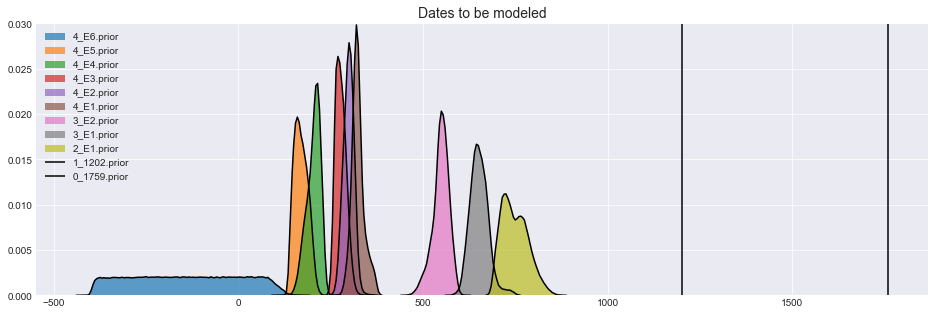

In [7]:
aliases = []
plt.figure(figsize=(16, 5))
# create an array of alias tables
for f in sorted(files, reverse=REVERSE):
    print("parsing", f)
    years, probs = parse_file(f)
    if not np.isclose(np.sum(probs), 1):
        norm = 1./np.sum(probs)
        probs = [p*norm for p in probs]
    if YEARLY:
        years, probs = increase_resolution(years, probs)
    alias = C14Date(probs, years)
    aliases.append(alias)
    if len(years) >  1:
        plt.plot(years, probs, c='k')
        plt.fill_between(years, 0, probs, label=f.split('/')[-1], alpha=0.7)
    else:
        # plot known dates with probability 1
        plt.vlines(years, 0, 0.05, label=f.split('/')[-1])
plt.ylim((0, 0.03))
plt.title("Dates to be modeled", size=14)
plt.legend(loc='upper left');
# for saving the figure, uncomment the wanted format
# plt.savefig(fname=path+'probabilities.png', dpi=300, format='png');
# plt.savefig(fname=path+'probabilities.eps', format='eps');

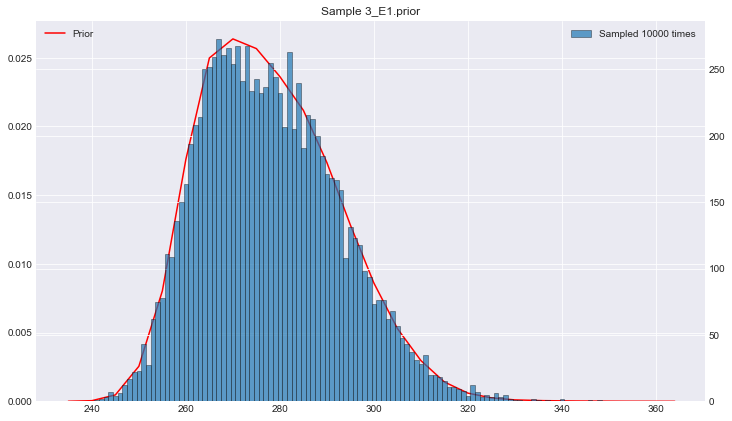

In [10]:
# sanity check - plot the samples and the original distribution of one random date
ind = np.random.randint(len(aliases))
years = aliases[ind].years
probs = aliases[ind].dist
sampled = aliases[ind].sample_years(NUM_SAMPLES)
nbins = len(years)
name = files[ind].split('/')[-1]

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(years, probs, '-r', label="Prior")
ax1.set_ylim([0,max(probs)*1.05])
plt.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.hist(sampled, bins=years, align='left', edgecolor="k", linewidth=0.5, alpha=0.7,
         label=f"Sampled {NUM_SAMPLES} times")
ax = plt.gca()
plt.xlabel("years")
plt.title("Sample %s" % name)
plt.legend();

In [11]:
recur = []
c = 0
while len(recur) < NUM_SAMPLES:
    years = [a.sample_years()[0] for a in aliases]  # sample all the distributions
    diffs = recurrence(years, MIN_RECURRENCE)
    if len(diffs) > 0:
        recur.append(diffs)
    else:
        c += 1
recur = np.array(recur)
if c > NUM_SAMPLES:
    print("With threshold %d had to resample %d times, \
    check if file order is correct" % (MIN_RECURRENCE, c))

We can now use those samples to calculate mean recurrence interval and coefficient of variation for the recurrence interval. After sampling `NUM_SAMPLES` times from all the dates and calculating the intervals between the samples, we average the recurrence interval for each generated sequence to get the mean $\mu$ recurrence interval and its corresponding standard deviation $\sigma$.

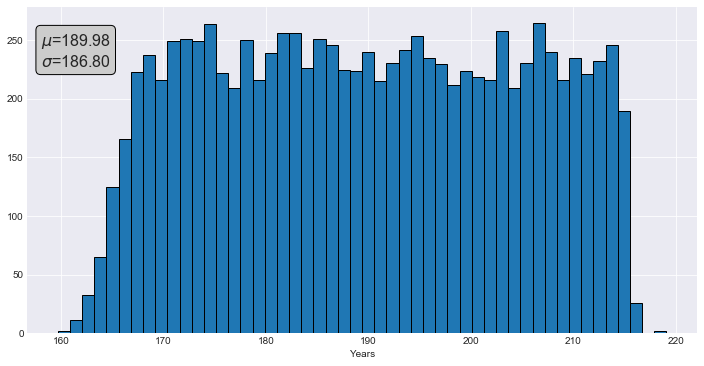

In [12]:
mu = np.mean(recur, axis=1)
sigma = np.std(recur, axis=1)
plt.figure(figsize=(12,6))
plt.hist(mu, bins=50, edgecolor="k")
plt.xlabel("Years")
ax = plt.gca()
ax.annotate("$\mu$=%.2f\n$\sigma$=%.2f" % (np.mean(mu), np.mean(sigma)),
            xy=(0.02, 0.7), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));
# for saving the figure, uncomment the wanted format
# plt.savefig(fname=path+'sampled_recurrence.png', dpi=300, format='png');
# plt.savefig(fname=path+'sampled_recurrence.eps', format='eps');

## Coefficient of Variation

The coefficient of variation is calculated thus:
$$
CV = \frac{\sigma}{\mu}
$$

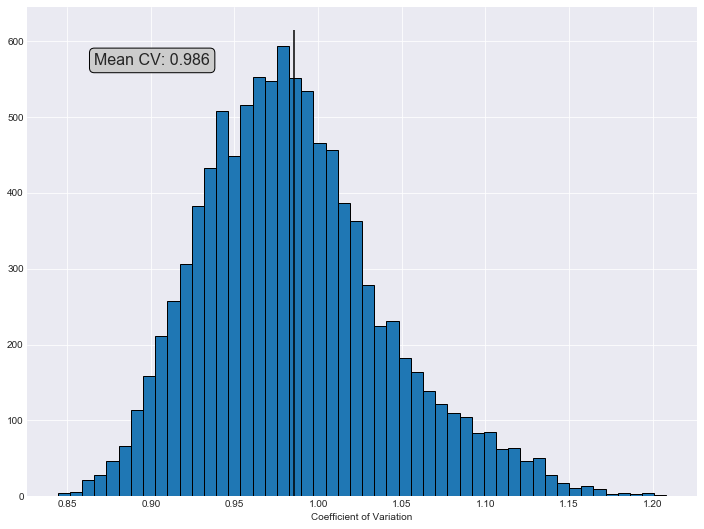

In [13]:
cv = sigma / mu
plt.figure(figsize=(12,9))
n, _, _ = plt.hist(cv, bins=50, edgecolor="k")
plt.vlines(np.mean(cv), 0, max(n)+20)
plt.xlabel("Coefficient of Variation")
ax = plt.gca()
ax.annotate("Mean CV: %.3f" % np.mean(cv),
            xy=(0.1, 0.8), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));
# for saving the figure, uncomment the wanted format
# plt.savefig(fname=path+'cv.png', dpi=300, format='png');
# plt.savefig(fname=path+'cv.eps', format='eps');

# Part II - slip per event

Estimating slip rate using slip-per-event based on C14 dates and measured offsets is a thorny problem, mostly because it is very difficult to model an offset estimate. The standard way of reporting a measurement of offset is by giving the most likely (very subjective) offset value $L$, be it measured in the field or from another source (like high-resolution topographic maps) and then giving it a "confidence interval" $\pm CI$ of plausible yet perhaps less likely values. 

In order to represent the uncertainty in offset we first need to quantify the error/uncertainty sources:

1. The method of measurement - resolution dependent. For example, an offsetted stream measured on a digital elevation map with resolution of 50 cm per pixel will have an error that is a function of the resolution $f(res)$.

2. The reconstruction uncertainty - observer and feature dependent. For example, when reconstrucing offset channels, do we match the channel thalweg or its edges? This is usually incorporated into 

3. The likelihood of the interpretation. In general it is common to refer to the first measurement estimate $L$ as the most likely value, but it can rarely be proven to be true.

Then there are several approaches on how to model the offset as a PDF (probability distribution function):

1. A gaussian distribution of the shape $\mathcal{N} (L, \sigma^2), \sigma^2=3\cdot CI$. The gaussian can be skewed if $CI^- \ne CI^+$

2. A triangle distribution with zeros at $L-CI^-, L+CI^+$ (the resolution error can be incorporates to extend the edges)and maximum at $L$.

3. A uniform distribution over the confindence interval (with or without the resolution error).

4. A hybrid distribution. For example using a trapesoidial shape with uniform probability for $L\pm f(res)$ and tapering it down to $[L - CI^- -f(res), L + CI^+ + f(res)]$. The taper can have many forms too - linear, logarithmic, etc.

Below There are examples of how to generate and plot such distributions for random sampling.

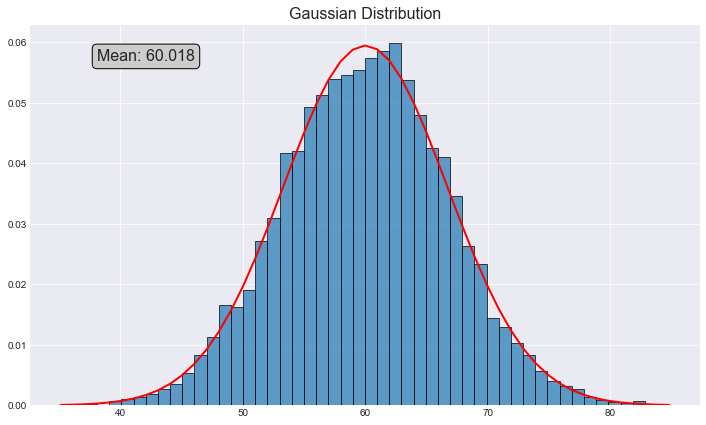

In [14]:
""" The Gaussian distribution

The tails of the distributions go beyond the confidence intervals and can be
thought of as representing a ~5% measurement resolution error
"""

L = 60 # this example will be in cm
ci = 15

sigma = np.sqrt(3*ci)
gaussian_sample = np.random.normal(L, sigma, 10000)  # notice that numpy asks for sigma and not sigma squared

_, ax = plt.subplots(figsize=(12, 7))
count, bins, ignored = plt.hist(gaussian_sample, 50, density=True, edgecolor='k', alpha=0.7)
plt.plot(bins, 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(bins-L)**2 / (2*sigma**2)),linewidth=2, color='r')
plt.title("Gaussian Distribution", size=16)
ax.annotate("Mean: %.3f" % np.mean(gaussian_sample),
            xy=(0.1, 0.8), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));

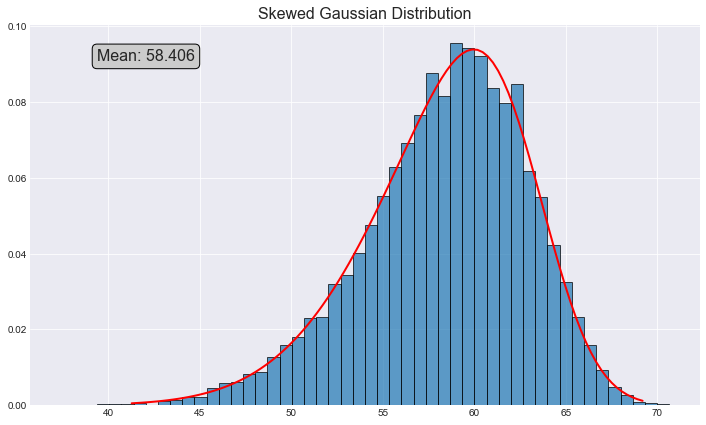

In [16]:
""" The Skewed Gaussian distribution

This is a more complicated case and it involves higher moments. Usually 
confidence intervals for the skewed normal involve calculating skewness
and kurtosis but I couldn't find a good example of how to estimate it 
backwards.
What I did here was basically guess the parameters to get something that
made sense visually. My goal was to set L=mod, that's why mu < L.
"""
from scipy.stats import skewnorm

L = 60 # this example will be in cm
ci_minus = 15
ci_plus = 10
res_err = 5

sigma = np.sqrt(3*ci)
a = (ci_plus - ci_minus)/2
gaussian_sample = skewnorm.rvs(a, loc=L+sigma/2, scale=sigma, size=10000)


x = np.linspace(skewnorm.ppf(0.001, a, loc=L+sigma/2, scale=sigma), 
                skewnorm.ppf(0.999, a, loc=L+sigma/2, scale=sigma), 100)

_, ax = plt.subplots(figsize=(12, 7))
plt.hist(gaussian_sample, 50, density=True, edgecolor='k', alpha=0.7)
plt.plot(x, skewnorm.pdf(x, a, loc=L+sigma/2, scale=sigma),linewidth=2, color='r')
plt.title("Skewed Gaussian Distribution", size=16)
ax.annotate("Mean: %.3f" % np.mean(gaussian_sample),
            xy=(0.1, 0.8), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));

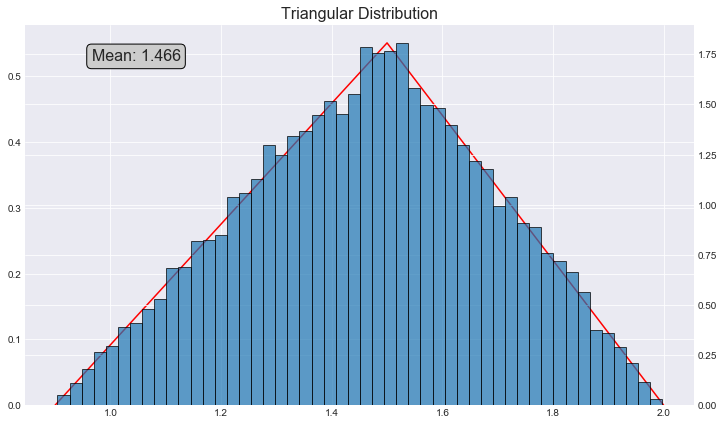

In [17]:
""" The triangular distribution

Dealing with skewness here is much easier.
It can be shown that the random sample mean does not exactly 
correspond to the distribution peak for skewed triangles 
"""

L = 1.5 # this example will be in meters
ci_minus = 0.4
ci_plus = 0.3
res_err = 0.2

tri_x = [L-(ci_minus+res_err), L, L+(ci_plus+res_err)]
tri_y = [0, (ci_minus/2+ci_plus/2+res_err), 0]
triangle_samples = np.random.triangular(L-(ci_minus+res_err), L, L+(ci_plus+res_err), 20000)

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(tri_x, tri_y, c='r')
ax1.set_ylim([0,max(tri_y)*1.05])
ax2 = ax1.twinx()
ax2.hist(triangle_samples, bins=50, edgecolor='k', density=True, alpha=0.7)
plt.title("Triangular Distribution", size=16)
ax2.annotate("Mean: %.3f" % np.mean(triangle_samples),
            xy=(0.1, 0.8), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));

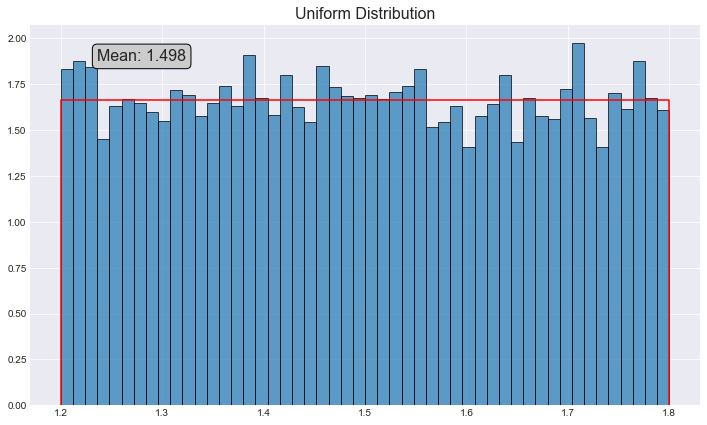

In [18]:
""" The Uniform distribution

This is the simplest and most naive approach.
No resolution error is used in this example.
In case of non-equal confidence intervals, the mean will not equal L.
"""

L = 1.5  # this example will be in meters
ci = 0.3

u_x = [L-ci, L-ci, L+ci, L+ci]
d = 1./(2*ci)
u_y = [0, d, d, 0]
uniform_samples = np.random.uniform(L-ci, L+ci, 10000)

_, ax = plt.subplots(figsize=(12, 7))
ax.plot(u_x, u_y, c='r')
ax.hist(uniform_samples, bins=50, edgecolor='k', density=True, alpha=0.7)
plt.title("Uniform Distribution", size=16)
ax.annotate("Mean: %.3f" % np.mean(uniform_samples),
            xy=(0.1, 0.8), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));

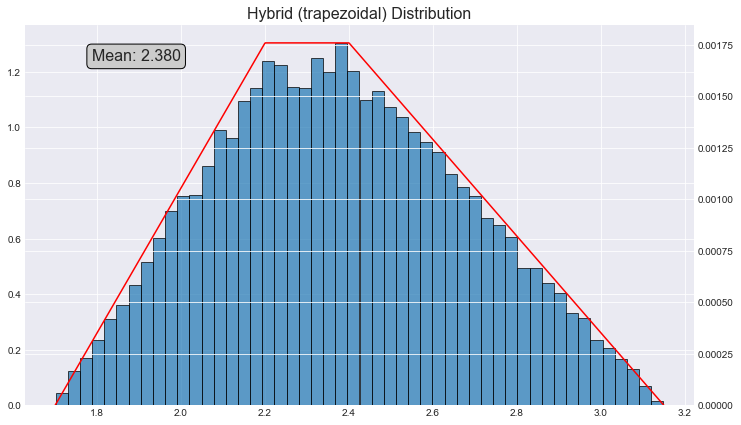

In [19]:
""" Hybrid - trapezoidal distribution 

An example of a custom random distribution
"""

L = 2.3  # this example will be in meters
ci_minus = 0.5
ci_plus = 0.75
res_err = 0.1

x = np.linspace(L-ci_minus-res_err, L+ci_plus+res_err, 1000)
y = np.zeros_like(x)
for i in range(len(x)):
    if x[i] < (L - res_err):
        y[i] = (x[i] - (L - ci_minus - res_err))/ci_minus
    elif x[i] > (L + res_err):
        y[i] = -(x[i] - (L + ci_plus + res_err))/ci_plus
    else:
        y[i] = 1

# normalize
y = y/np.sum(y)

# randomly sample from the distribution
al = Alias(y)
samples = [x[s] for s in al.sample(20000)]

_, ax1 = plt.subplots(figsize=(12, 7))
ax1.hist(samples, bins=50, edgecolor='k', density=True, alpha=0.7)
ax2 = ax1.twinx()
ax2.plot(x, y, c='r')
ax2.set_ylim([0,max(y)*1.05])
plt.title("Hybrid (trapezoidal) Distribution", size=16)
ax2.annotate("Mean: %.3f" % np.mean(samples),
            xy=(0.1, 0.8), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));